In [ ]:
import os
import pandas as pd
import wfdb
import numpy as np

# Укажите путь к вашей папке с датасетом:
data_root = "/Users/elizaveta/Downloads/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3"

# Загрузка метаданных:
db_csv = os.path.join(data_root, "ptbxl_database.csv")
df = pd.read_csv(db_csv, index_col="ecg_id")

df["filepath_hr"] = df["filename_hr"].apply(lambda fn: os.path.join(data_root, fn + ".dat"))

# Функция загрузки сигнала: тут 500 гц
def load_ptbxl_hr(ecg_id, fs=500):
    row = df.loc[ecg_id]
    fn = os.path.join(data_root, row["filename_hr"])
    sig, meta = wfdb.rdsamp(fn)
    sig = sig.T  # HuBERT-ECG ожидает (12, length)
    return sig, meta

# Тестовая загрузка:
ecg_id0 = df.index[0]
sig0, meta0 = load_ptbxl_hr(ecg_id0, fs=500)
print("Shape:", sig0.shape, "fs:", meta0["fs"])


Shape: (12, 5000) fs: 500


In [3]:
!pip install biosppy

  Using cached scikit_learn-1.7.2-cp313-cp313-macosx_12_0_arm64.whl.metadata (11 kB)
  Using cached joblib-1.5.2-py3-none-any.whl.metadata (5.6 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 48.0 kB/s  0:00:52 eta 0:00:05
Using cached joblib-1.5.2-py3-none-any.whl (308 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━ 22.5/37.9 MB 47.7 kB/s eta 0:05:22
Resuming download opencv_python-4.12.0.88-cp37-abi3-macosx_13_0_arm64.whl (22.5 MB/37.9 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.9/37.9 MB 88.3 kB/s  0:03:03m0:00:0200:13m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 47.0 kB/s  0:01:21m0:00:0300:09
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 65.3 kB/s  0:01:11m0:00:0200:06
Using cached scikit_learn-1.7.2-cp313-cp313-macosx_12_0_arm64.whl (8.6 MB)
Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.3.4
  

In [6]:
try:
    from biosppy.signals.tools import filter_signal
    print("✓ biosppy успешно загружен")
except ImportError:
    print("✗ biosppy не установлен, используем scipy версию")
    from scipy.signal import butter, filtfilt

✓ biosppy успешно загружен


In [7]:
from scipy.signal import resample
from biosppy.signals.tools import filter_signal

# Фильтрация, нормализация и ресемплинг 
def apply_filter(signal, filter_bandwidth, fs=500):
    order = int(0.3 * fs)
    signal, _, _ = filter_signal(signal=signal, ftype='FIR', band='bandpass',
                                 order=order, frequency=filter_bandwidth,
                                 sampling_rate=fs)
    return signal

def scaling(seq, smooth=1e-8):
    return 2 * (seq - np.min(seq, axis=1, keepdims=True)) / (np.max(seq, axis=1, keepdims=True) - np.min(seq, axis=1, keepdims=True) + smooth) - 1

def preprocess_hubert_ecg(sig, original_fs=500, target_fs=100, target_len_sec=5):
    # 1. Ресемплинг с 500 до 100 Гц
    n_target = int(target_len_sec * target_fs)
    sig = resample(sig, n_target, axis=1)
    # 2. Полосовой фильтр 0.05–47 Гц
    sig = apply_filter(sig, [0.05, 47], fs=target_fs)
    # 3. Нормализация [-1, 1]
    sig = scaling(sig)
    return sig

# Тест
ecg_id0 = df.index[0]
sig0, meta0 = load_ptbxl_hr(ecg_id0)
sig_pre = preprocess_hubert_ecg(sig0, original_fs=500, target_fs=100, target_len_sec=5)

print("Финальная форма для HuBERT-ECG:", sig_pre.shape)  # (12, 500)
print("Минимум/максимум:", sig_pre.min(), sig_pre.max())

Финальная форма для HuBERT-ECG: (12, 500)
Минимум/максимум: -1.0 0.9999999873300529


In [15]:
pip install torch transformers

  Using cached typing_extensions-4.15.0-py3-none-any.whl.metadata (3.3 kB)
  Using cached setuptools-80.9.0-py3-none-any.whl.metadata (6.6 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached pyyaml-6.0.3-cp313-cp313-macosx_11_0_arm64.whl.metadata (2.4 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached markupsafe-3.0.3-cp313-cp313-macosx_11_0_arm64.whl.metadata (2.7 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.5/74.5 MB 938.0 kB/s  0:01:04m0:00:0100:03
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 749.2 kB/s  0:00:15m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.1/566.1 kB 860.1 kB/s  0:00:00m-:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 339.6 kB/s  0:00:07 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 510.9 kB/s  0:00:05m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 1.3 MB/s  0:00:01 eta 0:00:01
Using cached pyyaml-6.0.3-cp313-cp313-maco

In [123]:
import os
import pandas as pd
import wfdb
import numpy as np
from scipy.signal import resample
from biosppy.signals.tools import filter_signal

# === 1. Пути ===
data_root = "/Users/elizaveta/Downloads/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3"

# === 2. Метаданные ===
db_csv = os.path.join(data_root, "ptbxl_database.csv")
df = pd.read_csv(db_csv, index_col="ecg_id")

# === 3. Загрузка сигнала (500 Гц) ===
def load_ptbxl_hr(ecg_id):
    row = df.loc[ecg_id]
    fn = os.path.join(data_root, row["filename_hr"])
    sig, meta = wfdb.rdsamp(fn)
    sig = sig.T  # (12, length)
    return sig, meta

# === 4. Предобработка ===
def apply_filter(signal, fs=100):
    order = int(0.3 * fs)
    signal, _, _ = filter_signal(signal=signal, ftype='FIR', band='bandpass',
                                 order=order, frequency=[0.5, 40],
                                 sampling_rate=fs)
    return signal

def scaling(seq, smooth=1e-8):
    return 2 * (seq - np.min(seq, axis=1, keepdims=True)) / (np.max(seq, axis=1, keepdims=True) - np.min(seq, axis=1, keepdims=True) + smooth) - 1

def preprocess_hubert_ecg(sig, original_fs=500, target_fs=100, target_len_sec=5):
    n_target = int(target_len_sec * target_fs)
    # 1. Обрезаем первые 5 секунд
    sig = sig[:, :int(target_len_sec * original_fs)]
    # 2. Ресемплинг 500 → 100 Гц
    sig = resample(sig, n_target, axis=1)
    # 3. Фильтрация 0.5–40 Гц
    sig = apply_filter(sig, fs=target_fs)
    # 4. Нормализация [-1, 1]
    sig = scaling(sig)
    return sig

# === 5. Тест ===
ecg_id0 = df.index[0]
sig0, meta0 = load_ptbxl_hr(ecg_id0)
sig_pre = preprocess_hubert_ecg(sig0)

print("Финальная форма для HuBERT-ECG:", sig_pre.shape)
print("Минимум/максимум:", sig_pre.min(), sig_pre.max())

Финальная форма для HuBERT-ECG: (12, 500)
Минимум/максимум: -1.0 0.9999999886558155


Rows in df: 21799
ecg_id                                                               1  \
patient_id                                                     15709.0   
age                                                               56.0   
sex                                                                  1   
height                                                             NaN   
weight                                                            63.0   
nurse                                                              2.0   
site                                                               0.0   
device                                                       CS-12   E   
recording_date                                     1984-11-09 09:17:34   
report                          sinusrhythmus periphere niederspannung   
scp_codes                     {'NORM': 100.0, 'LVOLT': 0.0, 'SR': 0.0}   
heart_axis                                                         NaN   
infarction_stadium1 

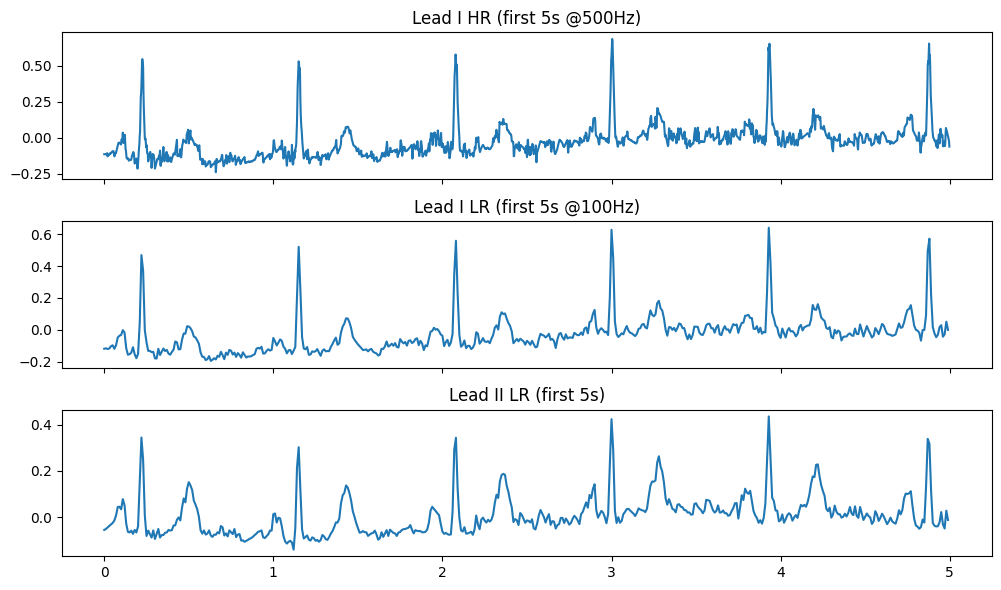

In [ ]:
# Блок 1: load & inspect one record
import os
import pandas as pd
import wfdb
import numpy as np
import matplotlib.pyplot as plt

data_root = "/Users/elizaveta/Downloads/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3"
db_csv = os.path.join(data_root, "ptbxl_database.csv")
df = pd.read_csv(db_csv, index_col="ecg_id")

print("Rows in df:", len(df))
print(df.iloc[:3].T)

# Выберем id первого реального примера
ecg_id0 = df.index[0]
print("Selected ecg_id:", ecg_id0)

# 1a) Загружаем HR (500 Hz) и LR (100 Hz) для сравнения
fn_hr = os.path.join(data_root, df.loc[ecg_id0, "filename_hr"])
fn_lr = os.path.join(data_root, df.loc[ecg_id0, "filename_lr"])

print("Files (hr, lr):", fn_hr, fn_lr)

sig_hr, meta_hr = wfdb.rdsamp(fn_hr)
sig_lr, meta_lr = wfdb.rdsamp(fn_lr)

print("HR shape (samples, channels):", sig_hr.shape, "meta fs:", meta_hr.get("fs"))
print("LR shape (samples, channels):", sig_lr.shape, "meta fs:", meta_lr.get("fs"))

# Транспонируем в (channels, samples) для удобства
sig_hr_t = sig_hr.T
sig_lr_t = sig_lr.T

print("Transposed shapes (channels, samples):", sig_hr_t.shape, sig_lr_t.shape)
print("First 3 values of lead I (hr):", sig_hr_t[0, :10])
print("First 3 values of lead I (lr):", sig_lr_t[0, :10])

# Визуализация: первые 5 секунд для HR и LR (несколько каналов)
fig, axes = plt.subplots(3,1, figsize=(10,6), sharex=True)
t_hr = np.arange(sig_hr_t.shape[1]) / float(meta_hr.get("fs",500))
t_lr = np.arange(sig_lr_t.shape[1]) / float(meta_lr.get("fs",100))

axes[0].plot(t_hr[:2500], sig_hr_t[0,:2500]); axes[0].set_title("Lead I HR (first 5s @{}Hz)".format(meta_hr.get("fs")))
axes[1].plot(t_lr[:500], sig_lr_t[0,:500]); axes[1].set_title("Lead I LR (first 5s @{}Hz)".format(meta_lr.get("fs")))
axes[2].plot(t_lr[:500], sig_lr_t[1,:500]); axes[2].set_title("Lead II LR (first 5s)")

plt.tight_layout()
plt.show()


Meta LR fs: 100
After preprocess: min/max per-channel: -1.0 0.9999999887447337
Processed shape: (12, 500) min,max: -1.0 0.9999999887447337


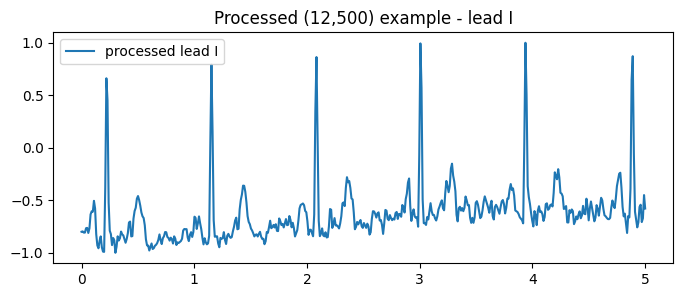

In [125]:
# Блок 2: preprocessing -> output (12,500), values in [-1,1]
from scipy.signal import resample
from biosppy.signals.tools import filter_signal

def apply_filter(signal, filter_bandwidth, fs=100):
    # FIR bandpass with biosppy wrapper (as in repo)
    order = int(0.3 * fs)
    s, _, _ = filter_signal(signal=signal, ftype='FIR', band='bandpass',
                            order=order, frequency=filter_bandwidth,
                            sampling_rate=fs)
    return s

def scale_minus1_1(seq, eps=1e-8):
    # per-channel linear to [-1,1]
    minv = np.min(seq, axis=1, keepdims=True)
    maxv = np.max(seq, axis=1, keepdims=True)
    out = 2 * (seq - minv) / (maxv - minv + eps) - 1
    return out

def preprocess_one(sig, orig_fs, target_fs=100, duration_sec=5, band=[0.5,40]):
    # sig expected shape: (channels, samples)
    channels, length = sig.shape
    assert channels == 12, "expected 12 leads"
    # take first duration_sec seconds (in original sampling)
    n_take = int(duration_sec * orig_fs)
    sig_cut = sig[:, :n_take]
    # resample to target_fs x duration_sec points
    n_target = int(duration_sec * target_fs)
    sig_rs = resample(sig_cut, n_target, axis=1)  # shape (12, n_target)
    # filter (note: filter_signal expects sampling_rate argument)!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! тут изменения
    sig_f = apply_filter(sig_rs, filter_bandwidth=[0.5,40], fs=target_fs)
    # scale to [-1,1]
    sig_s = scale_minus1_1(sig_f)
    # sanity checks
    assert sig_s.shape == (12, n_target)
    assert np.isfinite(sig_s).all()
    # range check
    print("After preprocess: min/max per-channel:", sig_s.min(), sig_s.max())
    return sig_s

# Тестим на ранее загруженном LR/HR
# выбираем LR или HR — предпочтительно LR (100Hz) чтобы не ресемплировать
print("Meta LR fs:", meta_lr.get("fs"))
sig_use = sig_lr_t  # можно подставить sig_hr_t, но тогда ресемпл в preprocess сделает 500->100
sig_proc = preprocess_one(sig_use, orig_fs=int(meta_lr.get("fs",100)), target_fs=100, duration_sec=5, band=[0.5,40])

print("Processed shape:", sig_proc.shape, "min,max:", sig_proc.min(), sig_proc.max())

# Визуализация: до/после lead I
import matplotlib.pyplot as plt
t = np.linspace(0, 5, sig_proc.shape[1])
plt.figure(figsize=(8,3))
plt.plot(t, sig_proc[0], label="processed lead I")
plt.title("Processed (12,500) example - lead I")
plt.legend()
plt.show()


In [ ]:
# Блок 3: inspect model expected conv in_channels, test forward pass (single example)
import torch
from transformers import AutoModel

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Device:", device)

hubert_ecg = AutoModel.from_pretrained("Edoardo-BS/hubert-ecg-base", trust_remote_code=True).to(device)
hubert_ecg.eval()

# Попытаемся найти первый Conv1d в feature extractor, чтобы узнать in_channels
def find_first_conv1d(model):
    for name, module in model.named_modules():
        from torch import nn
        if isinstance(module, nn.Conv1d):
            return name, module
    return None, None

conv_name, conv_module = find_first_conv1d(hubert_ecg)
print("First Conv1d found:", conv_name, conv_module)
if conv_module is not None:
    print("conv.in_channels, conv.out_channels, kernel_size:", conv_module.in_channels, conv_module.out_channels, conv_module.kernel_size)

x = torch.tensor(sig_proc, dtype=torch.float32).unsqueeze(0).to(device)  # (1, 12, 500)
print("x.shape:", x.shape)

# Сравним ожидания conv.in_channels и x.shape[1]
if conv_module is not None:
    print("Model expects in_channels =", conv_module.in_channels)
    assert x.ndim == 3
    if conv_module.in_channels != x.shape[1]:
        print("!!! WARNING: model first conv expects different in_channels than your data.")
        # если модель ожидает 1 канал, нужно адаптировать (см. ниже)
    else:
        print("in_channels match. Попытка пройти model.forward для одного примера...")

        with torch.no_grad():
            out = hubert_ecg(input_values=x)   # явный input_values
        print("Forward success. Output keys:", out.keys())
        # если last_hidden_state есть — распечатаем shape
        if hasattr(out, 'last_hidden_state'):
            print("last_hidden_state.shape:", out.last_hidden_state.shape)


Device: mps
First Conv1d found: feature_extractor.conv_layers.0.conv Conv1d(1, 512, kernel_size=(10,), stride=(4,), bias=False)
conv.in_channels, conv.out_channels, kernel_size: 1 512 (10,)
x.shape: torch.Size([1, 12, 500])
Model expects in_channels = 1
!!! WARNING: model first conv expects different in_channels than your data.


In [ ]:
import torch
import numpy as np
from transformers import AutoModel

device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print("Device:", device)

hubert_ecg = AutoModel.from_pretrained("Edoardo-BS/hubert-ecg-base", trust_remote_code=True).to(device)
hubert_ecg.eval()

ecg_id = df.index[0]
sig, meta = load_ptbxl_lr(ecg_id)
sig_pre = preprocess_one(sig)

lead_index = 1  # II отведение
lead_signal = sig_pre[lead_index]  # (500,)

# Преобразуем в нужный формат
x = torch.tensor(lead_signal, dtype=torch.float32)[None, :].to(device)  # (1, 500)
print("x.shape:", x.shape)

# Прогон через модель
with torch.no_grad():
    output = hubert_ecg(input_values=x)
    emb = output.last_hidden_state.mean(dim=1).cpu().numpy().flatten()

print("Embedding shape:", emb.shape)
print("First 10 values:", emb[:10])


Device: mps
x.shape: torch.Size([1, 500])
Embedding shape: (768,)
First 10 values: [ 0.52827173  0.6143454  -0.32911548  0.13836539 -0.31609282  1.5225774
  1.4284009  -0.7287213   0.12108503  0.35657457]


In [ ]:
import tqdm

n_samples = 3000  # количество сигналов для проверки
embeddings = []

for i, ecg_id in enumerate(tqdm.tqdm(df.index[:n_samples])):
    sig, meta = load_ptbxl_lr(ecg_id)
    sig_pre = preprocess_one(sig)
    
    # Берём II отведение
    lead_signal = sig_pre[1]  # lead II
    
    x = torch.tensor(lead_signal, dtype=torch.float32)[None, :].to(device)  # (1, 500)
    
    with torch.no_grad():
        output = hubert_ecg(input_values=x)
        emb = output.last_hidden_state.mean(dim=1).cpu().numpy().flatten()
    
    embeddings.append(emb)
    
    # Вывод первых 3 эмбеддингов для контроля
    if i < 3:
        print(f"ECG {i} embedding shape: {emb.shape}")
        print("First 10 values:", emb[:10])

embeddings = np.vstack(embeddings)
print("Final embeddings shape:", embeddings.shape)  # (3000, 768)


  0%|          | 6/3000 [00:00<01:38, 30.35it/s]

ECG 0 embedding shape: (768,)
First 10 values: [ 0.52827173  0.6143454  -0.32911548  0.13836539 -0.31609282  1.5225774
  1.4284009  -0.7287213   0.12108503  0.35657457]
ECG 1 embedding shape: (768,)
First 10 values: [-0.4320545   0.71546453 -0.46567923  0.22837894 -0.29328772 -0.18948169
  0.7189603  -0.04280936  0.09500289  1.0798225 ]
ECG 2 embedding shape: (768,)
First 10 values: [-0.41075152  0.27467564 -0.03629388 -0.08226412 -0.63029236  0.5503813
  1.5632323  -0.5737506   0.21597838  0.09035486]


100%|██████████| 3000/3000 [00:55<00:00, 53.74it/s]

Final embeddings shape: (3000, 768)


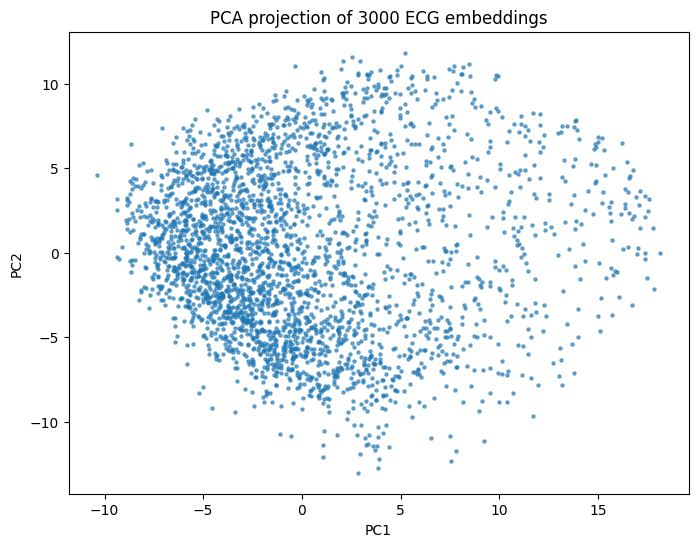

In [69]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
emb_2d = pca.fit_transform(embeddings)

plt.figure(figsize=(8,6))
plt.scatter(emb_2d[:,0], emb_2d[:,1], s=5, alpha=0.6)
plt.title("PCA projection of 3000 ECG embeddings")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


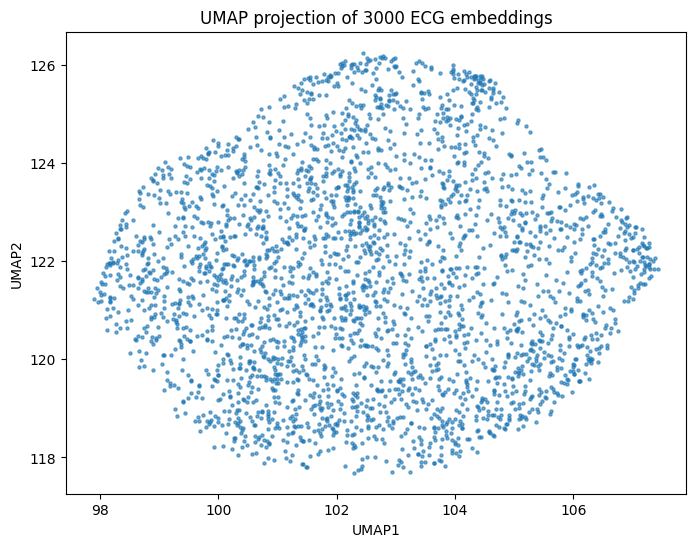

In [76]:
import umap

reducer = umap.UMAP(n_neighbors=50, min_dist=0.3, random_state=42)
emb_2d_umap = reducer.fit_transform(embeddings)

plt.figure(figsize=(8,6))
plt.scatter(emb_2d_umap[:,0], emb_2d_umap[:,1], s=5, alpha=0.6)
plt.title("UMAP projection of 3000 ECG embeddings")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.show()


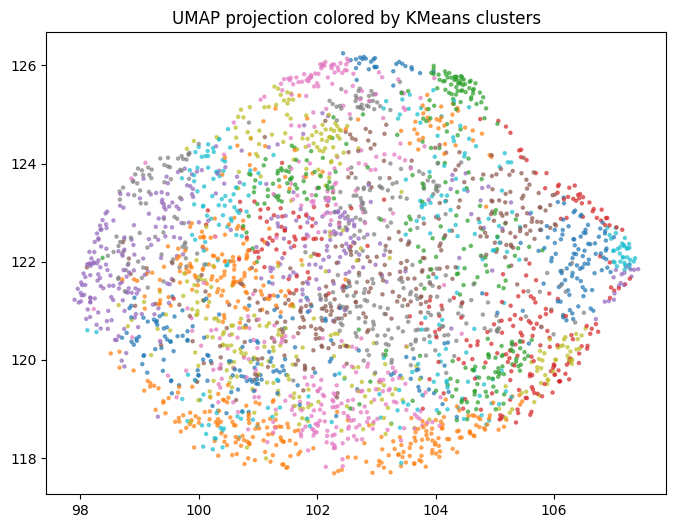

In [81]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=50, random_state=42)
labels = kmeans.fit_predict(embeddings)

plt.figure(figsize=(8,6))
plt.scatter(emb_2d_umap[:,0], emb_2d_umap[:,1], c=labels, cmap='tab10', s=5, alpha=0.6)
plt.title("UMAP projection colored by KMeans clusters")
plt.show()


In [82]:
for i in range(5):
    cluster_indices = np.where(labels == i)[0]
    print(f"\nCluster {i}, size: {len(cluster_indices)}")
    print(df.iloc[cluster_indices[:10]]['scp_codes'])  # первые 10 сигналов в кластере



Cluster 0, size: 26
ecg_id
177                            {'ASMI': 100.0, 'SR': 0.0}
348              {'LAFB': 100.0, 'LVOLT': 0.0, 'SR': 0.0}
691     {'ASMI': 100.0, 'IMI': 100.0, 'QWAVE': 0.0, 'A...
1021                           {'NORM': 100.0, 'SR': 0.0}
1049        {'ASMI': 100.0, 'LMI': 100.0, 'CRBBB': 100.0}
1136                {'NDT': 100.0, 'NT_': 0.0, 'SR': 0.0}
1173                        {'AFLT': 100.0, 'SVTAC': 0.0}
1327    {'AMI': 50.0, 'LVH': 35.0, 'LAO/LAE': 50.0, 'N...
1478                          {'CRBBB': 100.0, 'SR': 0.0}
1502                         {'NST_': 100.0, 'AFIB': 0.0}
Name: scp_codes, dtype: object

Cluster 1, size: 31
ecg_id
36                            {'NORM': 100.0, 'SR': 0.0}
39     {'IMI': 15.0, 'LNGQT': 100.0, 'NST_': 100.0, '...
87             {'NDT': 100.0, 'IRBBB': 100.0, 'SR': 0.0}
138                            {'LVH': 100.0, 'SR': 0.0}
169                          {'IRBBB': 100.0, 'SR': 0.0}
217                            {'NDT': 100.0, 'S

In [83]:
from sklearn.metrics import pairwise_distances

dist_matrix = pairwise_distances(embeddings[:3000])
intra_cluster = []
inter_cluster = []

for i in range(5):
    idx = np.where(labels[:3000] == i)[0]
    intra_cluster.append(dist_matrix[np.ix_(idx, idx)].mean())
    
# межкластерное расстояние
for i in range(5):
    for j in range(i+1, 5):
        idx_i = np.where(labels[:3000] == i)[0]
        idx_j = np.where(labels[:3000] == j)[0]
        inter_cluster.append(dist_matrix[np.ix_(idx_i, idx_j)].mean())

print("Average intra-cluster distance:", np.mean(intra_cluster))
print("Average inter-cluster distance:", np.mean(inter_cluster))


Average intra-cluster distance: 11.761801
Average inter-cluster distance: 20.429731


After preprocess: min/max per-channel: -1.0 0.9999999886604742
After preprocess: min/max per-channel: -1.0 0.9999999907045989
After preprocess: min/max per-channel: -1.0 0.9999999894823832
After preprocess: min/max per-channel: -1.0 0.9999999943381304
After preprocess: min/max per-channel: -1.0 0.9999999927456054


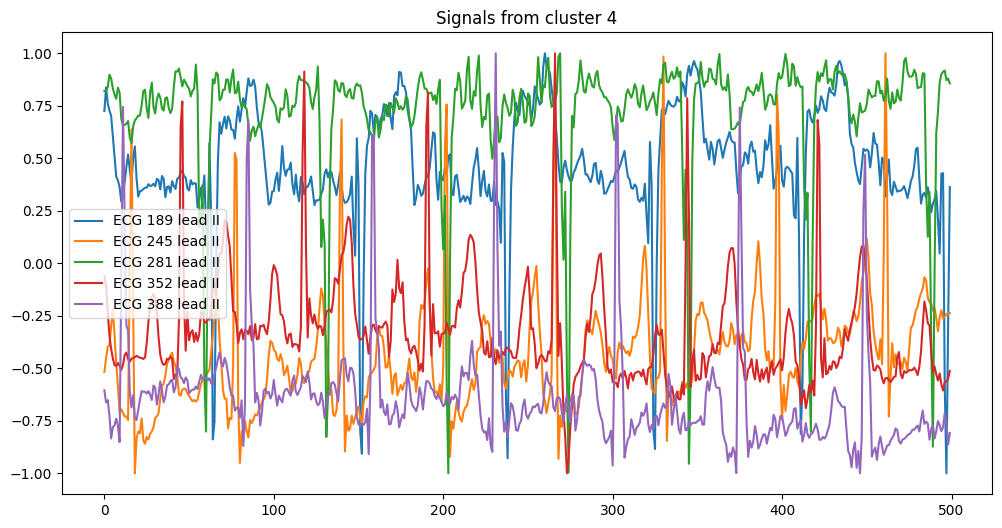

In [84]:
cluster_id = 4
cluster_indices = np.where(labels == cluster_id)[0][:5]

plt.figure(figsize=(12,6))
for i, idx in enumerate(cluster_indices):
    sig, meta = load_ptbxl_lr(df.index[idx])
    sig_proc = preprocess_one(sig, orig_fs=int(meta['fs']), target_fs=100, duration_sec=5, band=[0.5,40])
    plt.plot(sig_proc[1], label=f"ECG {df.index[idx]} lead II")  # II отведение
plt.legend()
plt.title(f"Signals from cluster {cluster_id}")
plt.show()


After preprocess: min/max per-channel: -1.0 0.9999999886604742
Visualizing ECG 189 from cluster 4


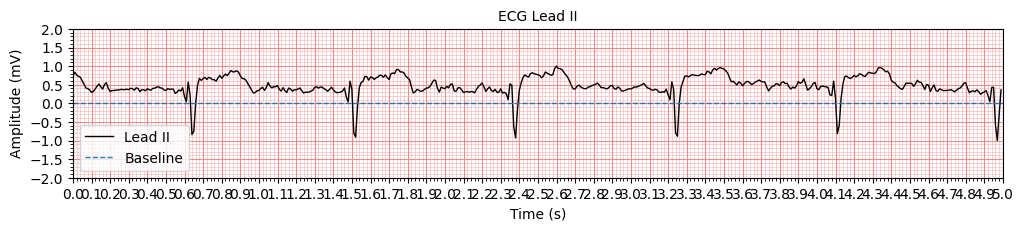

After preprocess: min/max per-channel: -1.0 0.9999999907045989
Visualizing ECG 245 from cluster 4


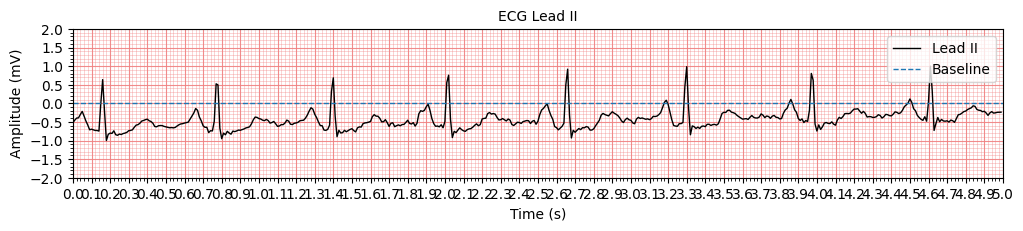

After preprocess: min/max per-channel: -1.0 0.9999999894823832
Visualizing ECG 281 from cluster 4


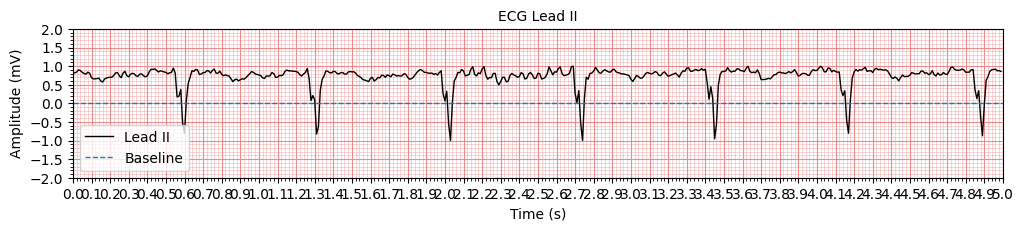

After preprocess: min/max per-channel: -1.0 0.9999999943381304
Visualizing ECG 352 from cluster 4


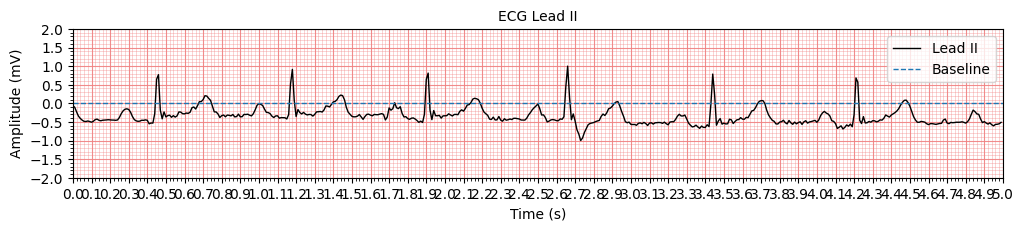

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

def visualize_lead(lead_result, baseline=0, fs=100, max_seconds=5):
    """
    Визуализирует сигнал конкретного отведения.
    lead_result: dict с ключами 'timeline_x' и 'clean_signal'
    baseline: уровень базовой линии
    fs: частота дискретизации
    max_seconds: максимальная длина по времени для отображения
    """
    x = np.array(lead_result['timeline_x'])
    y = np.array(lead_result['clean_signal'])

    if max_seconds:
        max_samples = int(max_seconds * fs)
        x = x[:max_samples]
        y = y[:max_samples]

    x_tick = 0.02  # шаг по X (секунды)
    y_tick = 0.1   # шаг по Y (мВ)

    fig, ax = plt.subplots(figsize=(12, 3))
    ax.plot(x, y, color='black', linewidth=1.0, label="Lead II")
    ax.set_aspect(x_tick / y_tick, adjustable='box')
    ax.set_xlim(0, max_seconds)
    ax.set_ylim(-2, 2)

    # Сетка
    ax.xaxis.set_minor_locator(MultipleLocator(x_tick))
    ax.yaxis.set_minor_locator(MultipleLocator(y_tick))
    ax.grid(which='minor', color='lightcoral', linewidth=0.4, alpha=0.6)
    ax.xaxis.set_major_locator(MultipleLocator(x_tick * 5))
    ax.yaxis.set_major_locator(MultipleLocator(y_tick * 5))
    ax.grid(which='major', color='lightcoral', linewidth=0.8, alpha=0.9)

    ax.axhline(y=baseline, linestyle='--', linewidth=1, label='Baseline')

    ax.set_title("ECG Lead II", fontsize=10)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Amplitude (mV)")
    ax.legend()
    plt.show()


cluster_id = 4  # пример: 4-й кластер
cluster_indices = np.where(labels == cluster_id)[0][:4]  # первые 4 записи из кластера

for i, idx in enumerate(cluster_indices):
    ecg_id = df.index[idx]
    
    # Загружаем и предобрабатываем
    sig, meta = load_ptbxl_lr(ecg_id)
    sig_proc = preprocess_one(sig, orig_fs=int(meta['fs']), target_fs=100, duration_sec=5, band=[0.5,40])
    
    # Формируем структуру для визуализации
    lead_result = {
        'timeline_x': np.arange(sig_proc.shape[1]) / 100,  # 100 Hz
        'clean_signal': sig_proc[1]  # II отведение
    }
    
    print(f"Visualizing ECG {ecg_id} from cluster {cluster_id}")
    visualize_lead(lead_result, baseline=0, fs=100, max_seconds=5)


In [93]:
# Выбираем все индексы ЭКГ в 4-м кластере
cluster_id = 4
cluster_indices = np.where(labels == cluster_id)[0]

# Собираем scp_codes для всех ЭКГ кластера
cluster_codes = df.iloc[cluster_indices]['scp_codes']

# Выводим первые 10 для примера
print("First 10 ECG in cluster 4 scp_codes:")
print(cluster_codes.head(10))

# Подсчёт частоты появления каждого кода
from collections import Counter
all_codes = []
for codes in cluster_codes:
    # scp_codes - это строка вида "{'NORM': 100.0, 'LVH': 50.0}" -> нужно превратить в dict
    codes_dict = eval(codes)  # безопасно, если данные доверенные
    all_codes.extend(codes_dict.keys())

code_counts = Counter(all_codes)
print("\nFrequency of each SCP code in cluster 4:")
for code, count in code_counts.most_common():
    print(code, count)


First 10 ECG in cluster 4 scp_codes:
ecg_id
189            {'ASMI': 100.0, 'ILMI': 100.0, 'SR': 0.0}
245                           {'NORM': 100.0, 'SR': 0.0}
281    {'ASMI': 100.0, 'ALMI': 100.0, 'IMI': 100.0, '...
352                           {'NORM': 100.0, 'SR': 0.0}
388                           {'NST_': 100.0, 'SR': 0.0}
428    {'CRBBB': 100.0, 'LAFB': 100.0, 'LPFB': 100.0,...
442               {'IMI': 15.0, 'LVOLT': 0.0, 'SR': 0.0}
472                           {'NORM': 100.0, 'SR': 0.0}
535    {'IPMI': 100.0, 'ASMI': 100.0, '1AVB': 100.0, ...
577            {'ASMI': 100.0, 'LAFB': 100.0, 'SR': 0.0}
Name: scp_codes, dtype: object

Frequency of each SCP code in cluster 4:
SR 49
NORM 24
IMI 11
LAFB 11
NDT 10
ASMI 7
STD_ 6
NST_ 5
AFIB 5
STACH 5
PAC 4
QWAVE 4
ISC_ 4
CRBBB 3
LPFB 3
1AVB 3
DIG 3
IRBBB 3
LVH 3
SBRAD 3
ILMI 2
LVOLT 2
IPMI 2
IVCD 2
INJAS 2
INVT 2
NT_ 2
LPR 2
ABQRS 2
LOWT 2
ALMI 1
STE_ 1
PVC 1
AMI 1
ISCAL 1
EL 1


In [94]:
import pandas as pd
from collections import Counter

n_clusters = 50  # твое количество кластеров

# Создаем словарь: ключ = номер кластера, значение = Counter всех scp_codes
cluster_code_counts = {}

for cluster_id in range(n_clusters):
    cluster_indices = np.where(labels == cluster_id)[0]
    cluster_codes = df.iloc[cluster_indices]['scp_codes']
    
    all_codes = []
    for codes in cluster_codes:
        codes_dict = eval(codes)  # строки вида "{'NORM': 100.0}" -> dict
        all_codes.extend(codes_dict.keys())
    
    cluster_code_counts[cluster_id] = Counter(all_codes)

# Преобразуем в DataFrame
df_cluster_codes = pd.DataFrame(cluster_code_counts).fillna(0).astype(int).T
df_cluster_codes.index.name = 'cluster_id'

# Сортируем коды по убыванию внутри каждого кластера для удобства
df_cluster_codes_sorted = df_cluster_codes.apply(lambda row: row.sort_values(ascending=False).index.tolist(), axis=1)

print("DataFrame с частотами SCP-кодов по кластерам:")
display(df_cluster_codes)

print("\nСписки наиболее частых SCP-кодов по кластерам:")
display(df_cluster_codes_sorted)


DataFrame с частотами SCP-кодов по кластерам:


,ASMI,SR,LAFB,LVOLT,IMI,QWAVE,AFIB,NORM,LMI,CRBBB,...,ISCLA,3AVB,2AVB,PRC(S),PSVT,SEHYP,INJIL,INJLA,ISCAN,TRIGU
cluster_id,,,,,,,,,,,,,,,,,,,,,
0,7,17,3,2,5,3,3,6,1,2,...,0,0,0,0,0,0,0,0,0,0
1,0,28,0,1,2,1,0,14,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,106,7,0,1,3,3,90,0,1,...,0,0,0,0,0,0,0,0,0,0
3,6,8,8,0,4,2,4,0,0,2,...,0,0,0,0,0,0,0,0,0,0
4,7,49,11,2,11,4,5,24,0,3,...,0,0,0,0,0,0,0,0,0,0
5,13,25,24,0,5,2,3,1,1,2,...,0,0,0,0,0,0,0,0,0,0
6,7,91,4,0,1,0,2,64,0,0,...,0,0,0,0,0,0,0,0,0,0
7,9,110,14,0,9,4,4,75,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,111,0,0,3,1,2,99,0,0,...,0,0,0,0,0,0,0,0,0,0



Списки наиболее частых SCP-кодов по кластерам:


cluster_id
0     [SR, ASMI, NORM, IMI, STACH, NST_, NT_, AFIB, ...
1     [SR, NORM, NDT, IRBBB, ISCAL, 1AVB, IMI, NT_, ...
2     [SR, NORM, LAFB, LVH, ASMI, NDT, IRBBB, STD_, ...
3     [PACE, LAFB, SR, ASMI, CLBBB, IMI, AFIB, 1AVB,...
4     [SR, NORM, LAFB, IMI, NDT, ASMI, STD_, AFIB, S...
5     [SR, LAFB, ASMI, LVH, IMI, STD_, AFIB, NT_, VC...
6     [SR, NORM, STD_, ISC_, LVH, NDT, ASMI, LOWT, L...
7     [SR, NORM, LAFB, STD_, LVH, NDT, ASMI, IMI, NT...
8     [SR, NORM, NDT, IRBBB, SARRH, LVH, STD_, LOWT,...
9     [SR, ASMI, CLBBB, NORM, LAFB, PVC, STACH, AFIB...
10    [SR, NORM, ASMI, LAFB, SBRAD, AFIB, STD_, IVCD...
11    [SR, CLBBB, 1AVB, ASMI, PVC, STACH, LVH, ISC_,...
12    [NORM, STACH, SR, ASMI, AFIB, IRBBB, LVH, STD_...
13    [SR, NORM, ASMI, LAFB, PVC, IMI, IRBBB, CRBBB,...
14    [SR, NORM, IRBBB, NDT, PVC, LVH, IMI, ASMI, IS...
15    [SR, NORM, IMI, NDT, IRBBB, NT_, INJAS, LOWT, ...
16    [SR, NORM, NDT, IRBBB, PAC, LVH, NST_, NT_, AS...
17    [SR, ASMI, NORM, IMI, NDT, LPR,

In [95]:
top_codes_per_cluster = df_cluster_codes.apply(lambda row: row.sort_values(ascending=False).head(5).index.tolist(), axis=1)
display(top_codes_per_cluster)


cluster_id
0       [SR, ASMI, NORM, IMI, STACH]
1      [SR, NORM, NDT, IRBBB, ISCAL]
2        [SR, NORM, LAFB, LVH, ASMI]
3      [PACE, LAFB, SR, ASMI, CLBBB]
4         [SR, NORM, LAFB, IMI, NDT]
5         [SR, LAFB, ASMI, LVH, IMI]
6        [SR, NORM, STD_, ISC_, LVH]
7        [SR, NORM, LAFB, STD_, LVH]
8      [SR, NORM, NDT, IRBBB, SARRH]
9      [SR, ASMI, CLBBB, NORM, LAFB]
10     [SR, NORM, ASMI, LAFB, SBRAD]
11      [SR, CLBBB, 1AVB, ASMI, PVC]
12     [NORM, STACH, SR, ASMI, AFIB]
13       [SR, NORM, ASMI, LAFB, PVC]
14       [SR, NORM, IRBBB, NDT, PVC]
15       [SR, NORM, IMI, NDT, IRBBB]
16       [SR, NORM, NDT, IRBBB, PAC]
17        [SR, ASMI, NORM, IMI, NDT]
18      [SR, NORM, ASMI, LAFB, STD_]
19        [SR, NORM, IMI, ASMI, LPR]
20    [NORM, SR, SBRAD, SARRH, ASMI]
21       [LVH, SR, AFIB, ISC_, ASMI]
22       [SR, STACH, NORM, IMI, LVH]
23      [SR, NORM, SBRAD, LVH, STD_]
24     [SR, NORM, IRBBB, STACH, NDT]
25        [SR, NORM, NDT, LAFB, IMI]
26      [SR, NORM, IMI, QWA

In [96]:
from sklearn.metrics import silhouette_score

silhouette = silhouette_score(embeddings, labels)
print(f"Silhouette score: {silhouette:.3f}")


Silhouette score: 0.052


/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/elizaveta/vs project/jupyter project/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


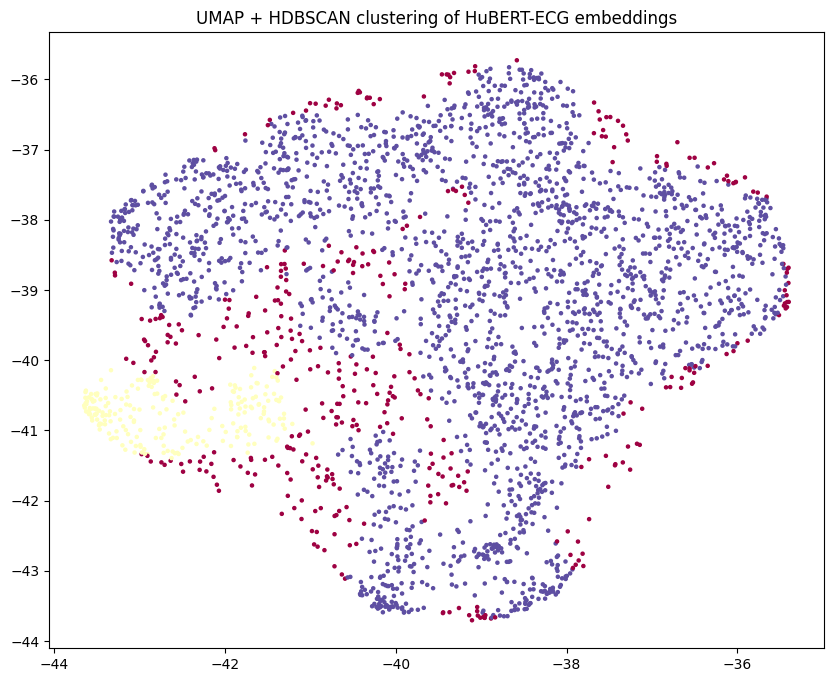

In [107]:
import umap
import hdbscan
import matplotlib.pyplot as plt

reducer = umap.UMAP(n_neighbors=30, min_dist=0.1, metric='euclidean')
umap_embeddings = reducer.fit_transform(embeddings)

clusterer = hdbscan.HDBSCAN(min_cluster_size=50, metric='euclidean')
labels = clusterer.fit_predict(umap_embeddings)

plt.figure(figsize=(10,8))
plt.scatter(umap_embeddings[:,0], umap_embeddings[:,1], c=labels, cmap='Spectral', s=5)
plt.title("UMAP + HDBSCAN clustering of HuBERT-ECG embeddings")
plt.show()


In [108]:
from sklearn.metrics import silhouette_score

silhouette = silhouette_score(embeddings, labels)
print(f"Silhouette score: {silhouette:.3f}")


Silhouette score: 0.061
